### InstaCart Online Grocery Recommendation 
Kaggle Hackathon \
The dataset is taken from Kaggle, \
https://www.kaggle.com/c/instacart-market-basket-analysis/data

### Objective:
- Build classification model to recommend groceries based on users past purchases.

## 1. Data Exploration (Pre-EDA)

In [1]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from scipy.sparse import csr_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df1 = pd.read_csv('/content/drive/MyDrive/instacart-market-basket-analysis/products/products.csv')

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [6]:
#Importing the dataset

df1 = pd.read_csv('/content/drive/MyDrive/instacart-market-basket-analysis/products/products.csv')
#display(df1.head())
print(df1.shape)
df2 = pd.read_csv('/content/drive/MyDrive/instacart-market-basket-analysis/aisles/aisles.csv')
#display(df2.head())
print(df2.shape)
df3 = pd.read_csv('/content/drive/MyDrive/instacart-market-basket-analysis/departments/departments.csv')
#display(df3.head())
print(df3.shape)
df4 = pd.read_csv('/content/drive/MyDrive/instacart-market-basket-analysis/order_products__train/order_products__train.csv')
#display(df4.head())
print(df4.shape)
df5 = pd.read_csv('/content/drive/MyDrive/instacart-market-basket-analysis/orders/orders.csv')
#display(df5.head())
print(df5.shape)

df12 = pd.merge(df2, df1, how='inner', on='aisle_id')
df123 = pd.merge(df12, df3, how='inner', on='department_id')
df1234 = pd.merge(df4, df123, how='inner', on='product_id')
df12345 = pd.merge(df5, df1234, how='inner', on='order_id')

df = df12345.drop(['aisle_id','department_id','eval_set','order_number'],axis=1)
display(df.head())
print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

(49688, 4)
(134, 2)
(21, 2)
(1384617, 4)
(3421083, 7)


,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle,product_name,department
0,1187899,1,4,8,14.0,49235,10,1,cream,Organic Half & Half,dairy eggs
1,1187899,1,4,8,14.0,46149,11,1,soft drinks,Zero Calorie Cola,beverages
2,1187899,1,4,8,14.0,196,1,1,soft drinks,Soda,beverages
3,1187899,1,4,8,14.0,27845,9,0,milk,Organic Whole Milk,dairy eggs
4,1187899,1,4,8,14.0,38928,3,1,yogurt,0% Greek Strained Yogurt,dairy eggs



Inference: The Datset consists of 11 features & 1384617 samples.


In [7]:
#Checking the dtypes of all the columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 0 to 1384616
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1384617 non-null  int64  
 1   user_id                 1384617 non-null  int64  
 2   order_dow               1384617 non-null  int64  
 3   order_hour_of_day       1384617 non-null  int64  
 4   days_since_prior_order  1384617 non-null  float64
 5   product_id              1384617 non-null  int64  
 6   add_to_cart_order       1384617 non-null  int64  
 7   reordered               1384617 non-null  int64  
 8   aisle                   1384617 non-null  object 
 9   product_name            1384617 non-null  object 
 10  department              1384617 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 126.8+ MB
None


In [8]:
#Checking number of unique rows in each feature

print(df.nunique().sort_values())

reordered                      2
order_dow                      7
department                    21
order_hour_of_day             24
days_since_prior_order        31
add_to_cart_order             80
aisle                        134
product_id                 39123
product_name               39123
order_id                  131209
user_id                   131209
dtype: int64


In [9]:
#Checking the stats of all the columns

display(df.describe())

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,1.031128e+05,2.701392e+00,1.357759e+01,1.706613e+01,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,5.948715e+04,2.167646e+00,4.238458e+00,1.042642e+01,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,5.173200e+04,1.000000e+00,1.000000e+01,7.000000e+00,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,1.029330e+05,3.000000e+00,1.400000e+01,1.500000e+01,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,1.549590e+05,5.000000e+00,1.700000e+01,3.000000e+01,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,2.062090e+05,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,8.000000e+01,1.000000e+00


**Inference:** The stats seem to be fine, let us gain more undestanding by visualising the dataset.

---

## 2. Exploratory Data Analysis (EDA)

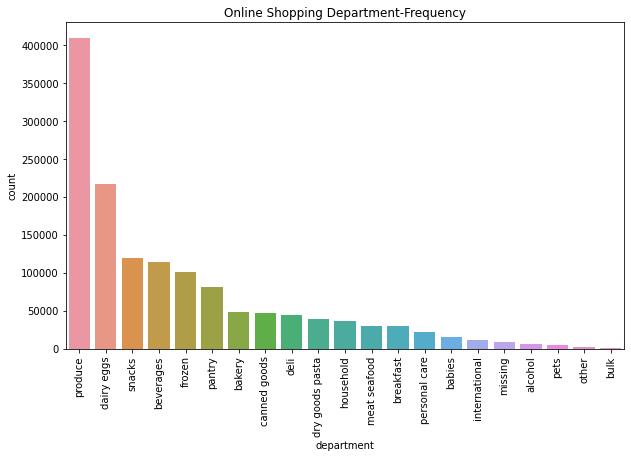

In [10]:
#Let us first analyze the department distribution

sns.countplot(df.department, order=df.department.value_counts().index)
plt.title('Online Shopping Department-Frequency')
plt.xticks(rotation=90)
plt.show()

**Inference:** The median of the majority votes seem to be at 3.5, while small number of votes are offered for 0.5 & 1...

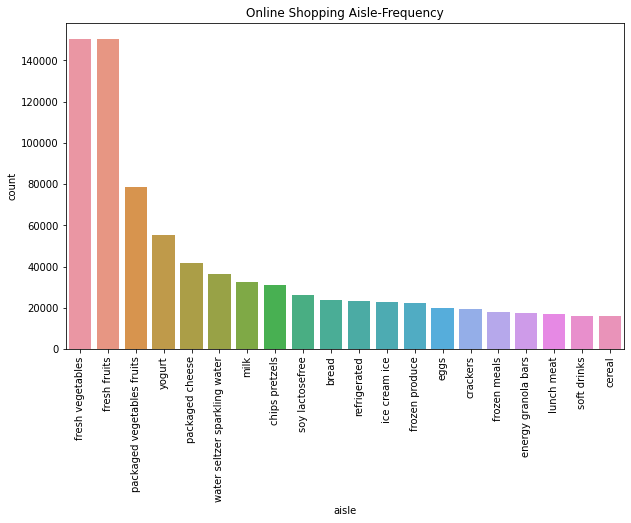

In [11]:
#Let us now analyze the aisle distribution

sns.countplot(df.aisle, order=df.aisle.value_counts().index[:20])
plt.title('Online Shopping Aisle-Frequency')
plt.xticks(rotation=90)
plt.show()

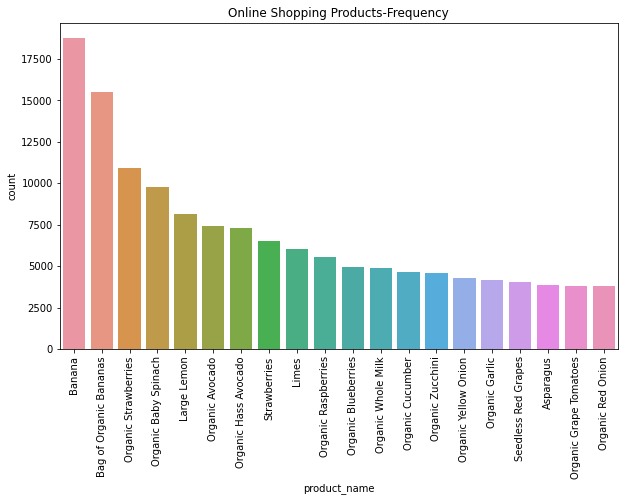

In [12]:
#Let us now analyze the products distribution

sns.countplot(df.product_name, order=df.product_name.value_counts().index[:20])
plt.title('Online Shopping Products-Frequency')
plt.xticks(rotation=90)
plt.show()

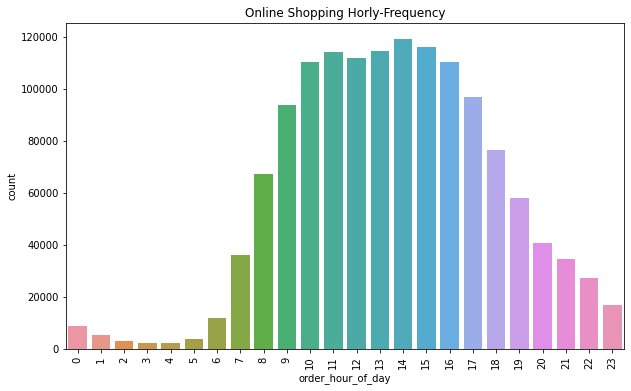

In [13]:
#Let us now analyze the hourly distribution

sns.countplot(df.order_hour_of_day)#, order=df.aisle.value_counts().index[:20])
plt.title('Online Shopping Horly-Frequency')
plt.xticks(rotation=90)
plt.show()

---

##3. Data Preprocessing

In [14]:
#Check for empty elements

print(df.isnull().sum())
print('\n\033[1mInference:\033[0m The dataset doesn\'t have any null elements')

order_id                  0
user_id                   0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
aisle                     0
product_name              0
department                0
dtype: int64

Inference: The dataset doesn't have any null elements


In [15]:
# Removal of any Duplicate rows (if any)
    
counter = 0
r,c = df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df.shape[0]}')
    


Inference: The dataset doesn't have any duplicates


In [16]:
dummies_df = pd.get_dummies(data=df, prefix=['Day','Hour'], columns=['order_dow','order_hour_of_day'], drop_first=True)
dummies_df.head()

,order_id,user_id,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle,product_name,department,Day_1,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1187899,1,14.0,49235,10,1,cream,Organic Half & Half,dairy eggs,0,...,0,0,0,0,0,0,0,0,0,0
1,1187899,1,14.0,46149,11,1,soft drinks,Zero Calorie Cola,beverages,0,...,0,0,0,0,0,0,0,0,0,0
2,1187899,1,14.0,196,1,1,soft drinks,Soda,beverages,0,...,0,0,0,0,0,0,0,0,0,0
3,1187899,1,14.0,27845,9,0,milk,Organic Whole Milk,dairy eggs,0,...,0,0,0,0,0,0,0,0,0,0
4,1187899,1,14.0,38928,3,1,yogurt,0% Greek Strained Yogurt,dairy eggs,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# #Final Dataset size after performing Preprocessing

# plt.title('Final Dataset Samples')
# plt.pie([df1.shape[0], df1.shape[0]-df.shape[0]], radius = 1, shadow=True,
#         labels=['Retained','Dropped'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0])
# plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
# plt.show()

# print('\n\033[1mInference:\033[0mThe final dataset after cleanup has {} samples & {} rows.'.format(df.shape[0], df.shape[1]))

---

## 4. Data Manipulation

In [18]:
user_prod_df = dummies_df.groupby(['user_id','product_id']).agg({'order_id':'nunique',
                                                                 'days_since_prior_order':'mean',
                                                                 'reordered':'max',
                                                                 'Day_1':'sum',
                                                                 'Day_2':'sum',
                                                                 'Day_3':'sum',
                                                                 'Day_4':'sum',
                                                                 'Day_5':'sum',
                                                                 'Day_6':'sum',
                                                                 'Hour_1':'sum',
                                                                 'Hour_2':'sum',
                                                                 'Hour_3':'sum',
                                                                 'Hour_4':'sum',
                                                                 'Hour_5':'sum',
                                                                 'Hour_6':'sum',
                                                                 'Hour_7':'sum',
                                                                 'Hour_8':'sum',
                                                                 'Hour_9':'sum',
                                                                 'Hour_10':'sum',
                                                                 'Hour_11':'sum',
                                                                 'Hour_12':'sum',
                                                                 'Hour_13':'sum',
                                                                 'Hour_14':'sum',
                                                                 'Hour_15':'sum',
                                                                 'Hour_16':'sum',
                                                                 'Hour_17':'sum',
                                                                 'Hour_18':'sum',
                                                                 'Hour_19':'sum',
                                                                 'Hour_20':'sum',
                                                                 'Hour_21':'sum',
                                                                 'Hour_22':'sum',
                                                                 'Hour_23':'sum'
                                                                }).reset_index()
user_prod_df.head()

,user_id,product_id,order_id,days_since_prior_order,reordered,Day_1,Day_2,Day_3,Day_4,Day_5,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1,196,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,10258,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,13032,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,25133,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,26088,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
user_purchase_df = dummies_df.groupby(['user_id']).agg({         'order_id':'nunique',
                                                                 'product_id': 'nunique',
                                                                 'days_since_prior_order':'mean',
                                                                 'reordered':'sum',
                                                                 'Day_1':'sum',
                                                                 'Day_2':'sum',
                                                                 'Day_3':'sum',
                                                                 'Day_4':'sum',
                                                                 'Day_5':'sum',
                                                                 'Day_6':'sum',
                                                                 'Hour_1':'sum',
                                                                 'Hour_2':'sum',
                                                                 'Hour_3':'sum',
                                                                 'Hour_4':'sum',
                                                                 'Hour_5':'sum',
                                                                 'Hour_6':'sum',
                                                                 'Hour_7':'sum',
                                                                 'Hour_8':'sum',
                                                                 'Hour_9':'sum',
                                                                 'Hour_10':'sum',
                                                                 'Hour_11':'sum',
                                                                 'Hour_12':'sum',
                                                                 'Hour_13':'sum',
                                                                 'Hour_14':'sum',
                                                                 'Hour_15':'sum',
                                                                 'Hour_16':'sum',
                                                                 'Hour_17':'sum',
                                                                 'Hour_18':'sum',
                                                                 'Hour_19':'sum',
                                                                 'Hour_20':'sum',
                                                                 'Hour_21':'sum',
                                                                 'Hour_22':'sum',
                                                                 'Hour_23':'sum'
                                                                }).reset_index()
user_purchase_df.head()

,user_id,order_id,product_id,days_since_prior_order,reordered,Day_1,Day_2,Day_3,Day_4,Day_5,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1,1,11,14.0,10,0,0,0,11,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,31,30.0,12,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,1,9,6.0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,1,9,6.0,8,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1,18,10.0,4,18,0,0,0,0,...,18,0,0,0,0,0,0,0,0,0


In [20]:
product_purchase_df = dummies_df.groupby(['product_id']).agg({   'order_id':'nunique',
                                                                 'user_id': 'nunique',
                                                                 'days_since_prior_order':'mean',
                                                                 'reordered':'sum',
                                                                 'Day_1':'sum',
                                                                 'Day_2':'sum',
                                                                 'Day_3':'sum',
                                                                 'Day_4':'sum',
                                                                 'Day_5':'sum',
                                                                 'Day_6':'sum',
                                                                 'Hour_1':'sum',
                                                                 'Hour_2':'sum',
                                                                 'Hour_3':'sum',
                                                                 'Hour_4':'sum',
                                                                 'Hour_5':'sum',
                                                                 'Hour_6':'sum',
                                                                 'Hour_7':'sum',
                                                                 'Hour_8':'sum',
                                                                 'Hour_9':'sum',
                                                                 'Hour_10':'sum',
                                                                 'Hour_11':'sum',
                                                                 'Hour_12':'sum',
                                                                 'Hour_13':'sum',
                                                                 'Hour_14':'sum',
                                                                 'Hour_15':'sum',
                                                                 'Hour_16':'sum',
                                                                 'Hour_17':'sum',
                                                                 'Hour_18':'sum',
                                                                 'Hour_19':'sum',
                                                                 'Hour_20':'sum',
                                                                 'Hour_21':'sum',
                                                                 'Hour_22':'sum',
                                                                 'Hour_23':'sum'
                                                                }).reset_index()
product_purchase_df.head()

,product_id,order_id,user_id,days_since_prior_order,reordered,Day_1,Day_2,Day_3,Day_4,Day_5,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1,76,76,17.118421,49,14.0,14.0,10.0,13.0,14.0,...,5.0,3.0,4.0,8.0,1.0,3.0,0.0,1.0,4.0,0
1,2,4,4,10.750000,1,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,3,6,6,21.000000,6,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4,22,22,17.272727,14,2.0,5.0,3.0,1.0,1.0,...,3.0,2.0,3.0,2.0,3.0,2.0,0.0,0.0,0.0,1
4,5,1,1,21.000000,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
temp = pd.merge(left=user_prod_df,  right=user_purchase_df, on='user_id', suffixes=('','_user'))
temp.head(10)

,user_id,product_id,order_id,days_since_prior_order,reordered,Day_1,Day_2,Day_3,Day_4,Day_5,...,Hour_14_user,Hour_15_user,Hour_16_user,Hour_17_user,Hour_18_user,Hour_19_user,Hour_20_user,Hour_21_user,Hour_22_user,Hour_23_user
0,1,196,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,10258,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,13032,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,25133,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,26088,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,26405,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1,27845,1,14.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,1,38928,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1,39657,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1,46149,1,14.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
features_df = pd.merge(left=temp,  right=product_purchase_df, on='product_id', suffixes=('','_prod'))
features_df.head(10)

,user_id,product_id,order_id,days_since_prior_order,reordered,Day_1,Day_2,Day_3,Day_4,Day_5,...,Hour_14_prod,Hour_15_prod,Hour_16_prod,Hour_17_prod,Hour_18_prod,Hour_19_prod,Hour_20_prod,Hour_21_prod,Hour_22_prod,Hour_23_prod
0,1,196,1,14.0,1,0,0,0,1,0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
1,67,196,1,5.0,1,0,0,0,0,0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
2,676,196,1,26.0,1,0,0,0,0,0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
3,760,196,1,8.0,1,0,0,0,1,0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
4,804,196,1,5.0,0,0,0,1,0,0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
5,865,196,1,30.0,0,0,0,0,0,1,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
6,992,196,1,30.0,1,0,0,0,0,1,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
7,1306,196,1,6.0,1,0,0,0,0,1,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
8,1512,196,1,27.0,0,1,0,0,0,0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16
9,1550,196,1,30.0,1,1,0,0,0,0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16


In [23]:
def my_reset(varnames):
    """
    varnames are what you want to keep
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)
    
variables = ['features_df']
my_reset(variables)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        col_type2 = df[col].dtype.name
        
        if ((col_type != object) and (col_type2 != 'category')):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [25]:
import numpy as np
reduce_features_df = reduce_mem_usage(features_df)

Memory usage of dataframe is 466.13 MB
Memory usage after optimization is: 273.34 MB
Decreased by 41.4%


In [26]:
reduce_features_df.isnull().sum().sort_values()

user_id                        0
Day_2_prod                     0
Day_1_prod                     0
reordered_prod                 0
days_since_prior_order_prod    0
                              ..
Hour_18                        0
Hour_17                        0
Hour_16                        0
days_since_prior_order_user    0
Hour_23_prod                   0
Length: 100, dtype: int64

In [27]:
reduced_feature= reduce_features_df[:1000]
reduced_feature

,user_id,product_id,order_id,days_since_prior_order,reordered,Day_1,Day_2,Day_3,Day_4,Day_5,...,Hour_14_prod,Hour_15_prod,Hour_16_prod,Hour_17_prod,Hour_18_prod,Hour_19_prod,Hour_20_prod,Hour_21_prod,Hour_22_prod,Hour_23_prod
0,1,196,1,14.0,1,0.0,0.0,0.0,1.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
1,67,196,1,5.0,1,0.0,0.0,0.0,0.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
2,676,196,1,26.0,1,0.0,0.0,0.0,0.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
3,760,196,1,8.0,1,0.0,0.0,0.0,1.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
4,804,196,1,5.0,0,0.0,0.0,1.0,0.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,136086,196,1,16.0,0,0.0,0.0,1.0,0.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
996,136300,196,1,7.0,1,0.0,0.0,0.0,0.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
997,136331,196,1,27.0,1,0.0,0.0,1.0,0.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0
998,136414,196,1,2.0,1,0.0,0.0,0.0,1.0,0.0,...,135.0,124.0,78.0,79.0,56.0,42.0,25.0,34.0,22.0,16.0


In [33]:
#Splitting Training & Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(reduced_feature, test_size=0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)

(700, 100)
(300, 100)


---

## <center> 5. Predictive Modeling

## K-Nearest Neighbours Classfier:

In [34]:
# Building Neareset Neighbours Classifier with Cosine distance measure

from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(X_train)

NearestNeighbors(algorithm='brute', metric='cosine')

In [35]:
import numpy as np
query_index = np.random.choice(X_train.shape[0])
distances, indices = model_knn.kneighbors(X_train.iloc[query_index, :].values.reshape((1, -1)), n_neighbors = 6)

j=1
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(X_train.index[indices.flatten()[i]]))
    else:
        try:
            print('{0}: {1}'.format(j, df1[df1['product_id']==X_train.index[indices.flatten()[i]]].product_name.values[0]))
            j+=1
        except:
            pass

Recommendations for 908:



---

## <center> 6. Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
- The Dataset was quiet large with combined data totally around 1.3M. 
- There were also few outliers & no duplicates present in the datset, which had to be dropped.
- Visualising the distribution of data & their relationships, helped us to get some insights on the relationship between the featureset.
- Further filtering was done with threshold for the number of user id's & product id's.
- Finally Nearest Neighbours Algorithm was employed to get the similar Groceries Recommendations based on the Cosine Similarity.